# Multi-armed Bandits

This is my implementation of the multi-armed bandit problem from [Reinforcement Learning: An Introduction - Sutton and Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html). With this I explore some of the options presented there for balancing exploration and exploitation.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

%matplotlib inline

## The problem set up

As in the book we have a set of possible actions, $a_i$, with rewards that are drawn from a normal distribution with $\mu = \mu_i$, $\sigma = 1$ where $\mu_i$ is itself drawn from a normal distribution with $\mu = 0$, $\sigma = 1$. We will choose actions for a set number of steps and want to maximise the reward we accumulate over these steps. To compare techniques we average out the variability by performing a large number of runs and measuring the average performance across them. Below we show the distribution of rewards for one example set of $\mu_i$.

optimal action:  9 , score:  2.68819678757


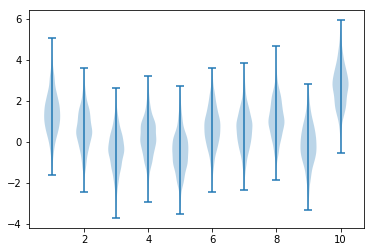

In [2]:
num_actions = 10
action_means = np.random.normal(size=(num_actions,), scale=1.0)
samples = np.random.normal(loc=action_means, size=(1000, num_actions))

optimal_action = np.argmax(action_means)
print("optimal action: ", optimal_action, ", score: ", action_means[optimal_action])

fig = plt.figure()
ax = plt.gca()
ax.violinplot(samples)
plt.show()

By drawing a set of action means multiple times we can see the average score for the optimal action. Calculating the theoretical expected max of iid samples is complex but estimating it empirically is easy.

In [3]:
num_runs = 2000
all_action_means = np.zeros((num_runs, num_actions))
for run in range(num_runs):
    all_action_means[run, :] = np.random.normal(size=(num_actions,), scale=1.0)

average_optimal_value = np.mean(np.amax(all_action_means, axis=1))
print(average_optimal_value)

1.53272591169


Later we will look at non-stationary problems in which the means change at each step as we sample them. In particular at each step we will add a value drawn from a normal distribution with $\mu = 0$, $\sigma = 0.01$. As a precursor we plot how the average optimal value changes as we add random noise to the action means. As expected it increases each time we add random noise. This is because the sum of 2 normally distributed random variables is normally distributed with $\mu = \mu_1 + \mu_2$ and $\sigma = \sqrt{\sigma_1^2 + \sigma_2^2}$, i.e. the action means get more spread out so the maximum gets larger. After 10000 steps of adding a random variable with standard deviation of 0.01, our 10 actions are distributed according to a normal distribution with variance of $\sigma = \sqrt{1 + 10000*0.0001} = \sqrt{2}$. We show this value below.

In [17]:
all_action_means = np.zeros((num_runs, num_actions))
for run in range(num_runs):
    all_action_means[run, :] = np.random.normal(size=(num_actions,), scale=np.sqrt(2.0))

average_optimal_value = np.mean(np.amax(all_action_means, axis=1))
print(average_optimal_value)

2.17525848421


We can show that this is the same as if we added 10000 random variables with $\mu = 0$, $\sigma = 0.01$.

2.18740697793


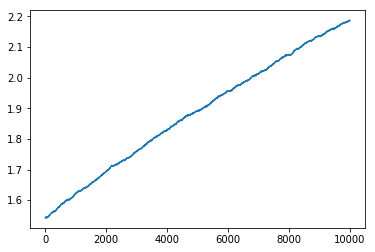

In [18]:
num_steps = 10000
action_means_runs_steps = np.zeros((num_runs, num_steps, num_actions))
for run in range(num_runs):
    current_action_means = np.random.normal(size=(num_actions,), scale=1.0)
    for step in range(num_steps):
        current_action_means += np.random.normal(size=(num_actions,), scale=0.01)
        action_means_runs_steps[run, step, :] = current_action_means
average_optimal_value = np.mean(np.amax(action_means_runs_steps, axis=2), axis=0)
plt.figure()
plt.plot(average_optimal_value)
print(average_optimal_value[-1])

## Applying reinforcement learning

Moving on to the reinforcement learning problem, we want to select actions which maximise our cumulative reward over the duration of a run. To do so we must learn what rewards each action will give. We keep an estimate of the expected reward for each possible action which we call the $Q$ values. Our policy will be to choose a random action with probability $\varepsilon$ (in this case all actions have equal probability of being chosen) or else choose the action which we expect to give the highest reward with probability $1 - \varepsilon$. This policy is implemented below.

In [5]:
def epsilon_greedy_action(q_values, epsilon, action_means):
    '''Select action using epsilon greedy policy'''
    random_value = np.random.random()
    choose_random = random_value < epsilon
    if choose_random:
        action = np.random.choice(len(q_values))
    else:
        action = np.argmax(q_values)
    
    reward = np.random.normal(loc=action_means[action])
    
    return action, reward

For a given set of action means in a single run we consider a number of single step episodes (by default 1000). We initialise all of the $Q$ values to $0$ (or another number if one is passed in). On each step, $t$ we select an action, $a_t$, and get the reward $r_t$ using the policy above and then update the $Q$ value of the selected action by adding some function $\alpha(n_{a,t})$ times the error between the reward sampled and the previous estimate of the reward. $n_{a,t}$ is a count of the number of times we have selected $a$ during this run. The update at each step is therefore $Q_t = Q_{t-1} + \alpha(n_{a,t})(r_t - Q_{t-1})$ . 

In [6]:
def calculate_rewards_for_run(epsilon, action_means, alpha, num_steps=1000, start_q_value=0.0):
    '''
    Given a set of action means use an epsilon greedy policy to select actions num_steps times. 
    Update the q value by moving towards the reward returned by a distance of alpha(num times action sampled)
    '''
    q_values = np.full((action_means.shape[1],), start_q_value)
    num_entries = np.zeros((action_means.shape[1],))

    rewards = np.zeros((num_steps,))
    actions = np.zeros((num_steps,))
    for step in range(num_steps):
        step_action_means = action_means[step, :]
        action, reward = epsilon_greedy_action(q_values, epsilon, step_action_means)
        actions[step] = action
        rewards[step] = reward
        num_entries[action] += 1
        current_alpha = alpha(num_entries[action])
        q_values[action] += current_alpha*(reward - q_values[action])
                
    return rewards, actions

There are various options for the $\alpha$ function. If we use $\alpha(n_{a,t}) = \frac{1}{n_{a,t}}$ then our $Q$ value estimate is the empirical mean of the rewards sampled in this state. Another option which we will later see helps us to deal with non-stationary problems is to use a constant value for $\alpha$.

In [7]:
def alpha_mean(step):
    '''Return value of alpha which lets q estimate the mean reward'''
    return 1/step

def alpha_const(const):
    '''Return an alpha function which always gives a constant value'''
    
    def alpha_func(step):
        '''Return a constant value'''
        return const
    
    return alpha_func

To see the behaviour of this setup we take a large number of runs and return the rewards received and actions taken, also returning the optimal action for each step in each run. We implement a random walk on the means, which means that the optimal action changes over the course of the run. We do this for multiple $\varepsilon$ values.

In [21]:
def average_rewards_over_runs(epsilons=[0, 0.1, 0.01], num_runs=2000, num_steps=1000, num_actions=10,
                              alpha=alpha_mean, random_walk_size=None, start_q_value = 0.0):
    '''
    For a multi-armed bandit problem with num_actions arms, return the rewards received and actions chosen
    for a number of runs each with a number of steps. Also return the optimal action choice each step and run.
    Evaluate this for a set of epsilon values which can be passed in.
    Optionally specify the alpha function used to update the q value estimates of the action values.
    Optionally make this a non-stationary problem by specifying that a random amount be added to each action
    at each step of each run.
    Optionally specify the initial estimate of the value of each action.
    '''
    all_runs_rewards = np.zeros((num_runs, num_steps, len(epsilons)))
    all_runs_actions = np.zeros((num_runs, num_steps, len(epsilons)), dtype=int)
    optimal_actions = np.zeros((num_runs, num_steps), dtype=int)
    optimal_rewards = np.zeros((num_runs, num_steps))
    for run in range(num_runs):
        step_action_means = np.random.normal(size=(num_actions,))
        action_means = np.zeros((num_steps, num_actions))
        random_steps = None
        for step in range(num_steps):
            if not (random_walk_size is None):
                step_action_means += np.random.normal(size=(num_actions,), scale=random_walk_size)
            action_means[step, :] = step_action_means
        
        optimal_actions[run, :] = np.argmax(action_means, axis=1)
        optimal_rewards[run, :] = action_means[np.arange(action_means.shape[0]), optimal_actions[run, :]]
        for (index, epsilon) in enumerate(epsilons):
            rewards, actions = calculate_rewards_for_run(epsilon, action_means, alpha, num_steps, 
                                                         start_q_value=start_q_value)
            all_runs_rewards[run, :, index] = rewards
            all_runs_actions[run, :, index] = actions
    
    return all_runs_rewards, all_runs_actions, optimal_actions

Given a set of runs for multiple $\varepsilon$ values we plot the average (across runs) reward against the step number. We also plot the percentage of the time that the optimal action is chosen against the step number.

In [9]:
def plot_average_reward_and_optimal_actions(all_runs_rewards, all_runs_actions, optimal_actions, 
    labels=["$\epsilon = 0$", "$\epsilon = 0.1$", "$\epsilon = 0.01$"]):
    '''
    Plot the average reward across runs against the step number. Plot the percentage of the time
    that the optimal action is chosen
    '''

    assert(all_runs_rewards.shape[2] == len(labels))
    plt.figure()
    for index in range(len(labels)):
        plt.plot(np.mean(all_runs_rewards[:, :, index], axis=0), label=labels[index])
    plt.legend()

    fig = plt.figure()
    for index in range(len(labels)):
        plt.plot(np.mean(all_runs_actions[:, :, index] == optimal_actions, 
                         axis=0), 
                 label=labels[index])
    plt.legend()
    ax = fig.gca()
    ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()]) 
    

## Results

Now that we have set these functions up, we can see some results. First we run a 10 armed bandit problem with stationary means for 1000 steps in 2000 runs with an $\alpha$ function which just calculates the mean reward per action. We use an $\varepsilon$ greedy policy with 3 different values of $\varepsilon$: $0, 0.1, 0.01$. We see that the greedy policy ($\varepsilon = 0$) does not on average get higher than $1$. This is because when it finds a value for which the average remains greater then the initial $Q$ value ($0$) it does not explore any other actions.

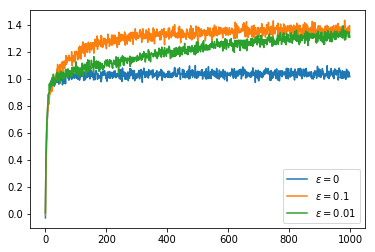

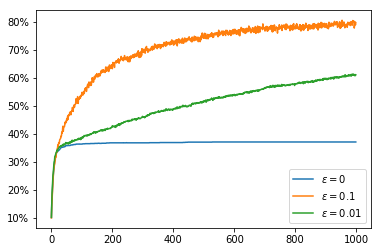

In [22]:
all_runs_rewards, all_runs_actions, optimal_actions = average_rewards_over_runs()
plot_average_reward_and_optimal_actions(all_runs_rewards, all_runs_actions, optimal_actions)

To address the problem of not exploring all of the options in the greedy cases, one option is to give an intentionally optimistic initial estimate of the $Q$ values. This way when we sample an action it will inevitably disappoint us and so the unsampled actions will seem more appealing. If we have $\alpha(n_{a,t}) = \frac{1}{n_{a,t}}$ so that $Q$ calculates the mean then after a single sample we lose our initial $Q$ value estimate. Nonetheless, this encourages exploration of all actions at least once. This improves the greedy policy so that it picks the optimal action about 70% of the time. Of course the less greedy policies improve over this over time with the $\varepsilon = 0.1$ policy climbing to 80% optimal policy choice. In the graphs we can see that the greedy policies get a higher reward than the $\varepsilon = 0.1$ policy even after it begins choosing the optimal action more often. This is because the greedy policies always choose an action which is close to optimal even if it is not quite the most optimal whereas the $\varepsilon = 0.1$ policy chooses a completely arbitrary action 10% of the time which brings down its average reward.

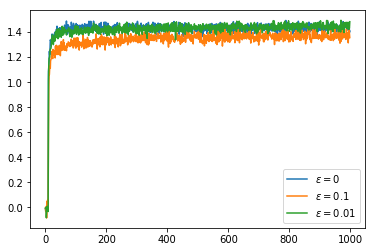

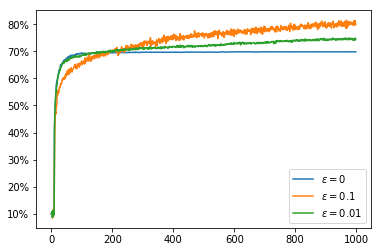

In [23]:
all_runs_rewards, all_runs_actions, optimal_actions = average_rewards_over_runs(start_q_value=5.0)
plot_average_reward_and_optimal_actions(all_runs_rewards, all_runs_actions, optimal_actions)

If we now switch to using a constant value of $\alpha$ we can obtain better rewards and a higher rate of choosing the optimal action. Even the greedy policy keeps improving over time because we never become completely certain that we have the best action, it just takes a few bad rewards in a row to convince us to try our luck with a different action.

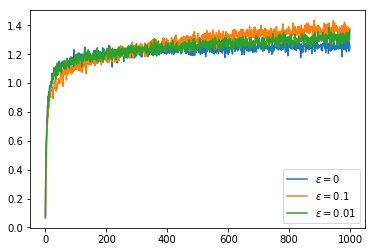

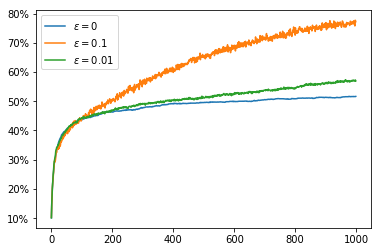

In [24]:
all_runs_rewards, all_runs_actions, optimal_actions = average_rewards_over_runs(alpha=alpha_const(0.1))
plot_average_reward_and_optimal_actions(all_runs_rewards, all_runs_actions, optimal_actions)

If we use a constant $\alpha$ in conjunction with an overly optimistic initial $Q$ value we do even better with our greedy policies. Unlike when we used the mean reward for our $Q$ value, we do not lose our optimism immediately after our first sample of an action, instead we sample actions many times before we are convinced that we had overestimated $Q$. This extra exploration means that once we have adjusted our $Q$ values to reasonable estimates we have explored enough that we are able to identify the optimal action far more often. 

At the beginning of the runs we get spikes where the average reward is much higher on average than on the steps to either side. This is because at first the optimistic initialisation causes us to try each action once and the $Q$ value for each action decreases, after each action has been tried we choose the action for which the $Q$ value decreased the least which is likely to be from a distribution with a better mean, so on this particular step of each run we are more likely to choose the optimal action.

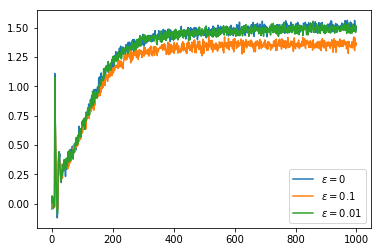

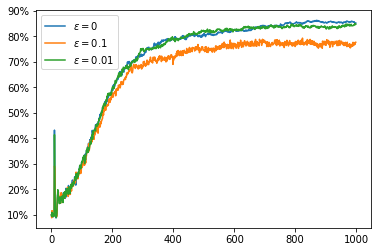

In [25]:
all_runs_rewards, all_runs_actions, optimal_actions = average_rewards_over_runs(alpha=alpha_const(0.1),
                                                                                start_q_value=5.0)
plot_average_reward_and_optimal_actions(all_runs_rewards, all_runs_actions, optimal_actions)

We now try the non-stationary problem, here we use runs with 10000 steps so that we can see the effect of the non-stationarity over a longer time period. If we simply use the average reward as our $Q$ value estimate it takes an increasing number of samples to change our minds about which action to select. This can be seen in the fact that the percentage of the time that we choose the optimal action decreases over the course of the run. The rewards obtained actually increase over the course of the run but, as we saw earlier, the random walk increases the available rewards so this does not indicate that we are doing well.

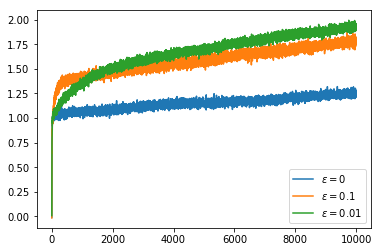

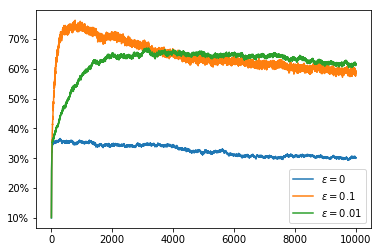

In [26]:
all_runs_rewards, all_runs_actions, optimal_actions = \
    average_rewards_over_runs(random_walk_size=0.01, num_steps=10000)
plot_average_reward_and_optimal_actions(all_runs_rewards, all_runs_actions, optimal_actions)

Setting the $Q$ value to have an optimistic initial estimate does not solve the problem as this only encourages exploration at the very start of the run and the optimal action changes through the course of the run.

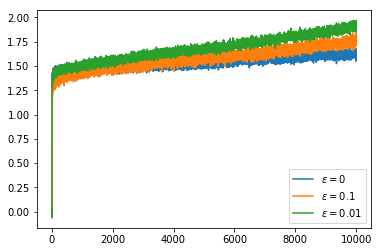

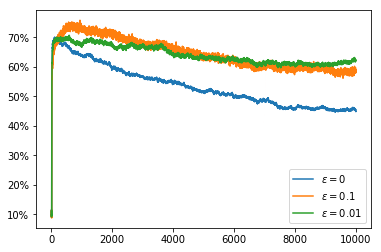

In [28]:
all_runs_rewards, all_runs_actions, optimal_actions = \
    average_rewards_over_runs(random_walk_size=0.01, num_steps=10000, start_q_value=5.0)
plot_average_reward_and_optimal_actions(all_runs_rewards, all_runs_actions, optimal_actions)

However, if we switch back to using a constant $\alpha$ again we can see that the non-stationarity of the problem does not cause nearly as much of a problem.

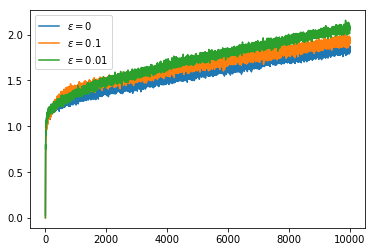

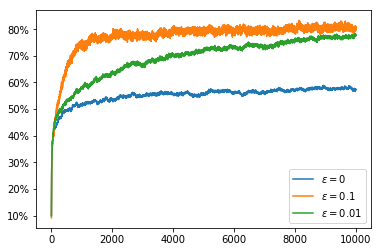

In [27]:
all_runs_rewards, all_runs_actions, optimal_actions = \
    average_rewards_over_runs(alpha=alpha_const(0.1), random_walk_size=0.01, num_steps=10000)
plot_average_reward_and_optimal_actions(all_runs_rewards, all_runs_actions, optimal_actions)